In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sensors import mse, dict2vect, vect2dict
import scipy
from scipy.sparse import linalg
from multiprocess import Pool 
import heapq
from tqdm.notebook import tqdm

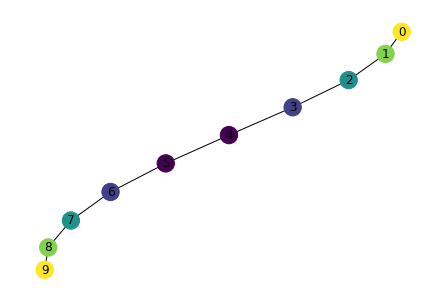

In [123]:
G = nx.path_graph(10)
eigs = np.linalg.eig(nx.laplacian_matrix(G, nodelist=G.nodes()).toarray())
x = eigs[1][:,-1]
nx.draw(G, with_labels=True, node_color=x)

In [353]:
def transition_matrix(G):
    A = np.array(nx.adjacency_matrix(G).todense())
    D_inv = np.diag([1 / x for x in np.sum(A, axis=0)])
    return np.dot(D_inv, A)

P = transition_matrix(G)
P - P.transpose()

array([[ 0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ]])

In [264]:
from scipy.linalg import lu_factor, lu_solve

m = G.number_of_nodes()
k = 5
S = np.array(sorted(list(sensors)))
T = np.array(sorted(list(set(range(m)) - sensors)))

P_TT = P[np.ix_(T, T)]
P_TS = P[np.ix_(T, S)]

lu, piv = lu_factor(np.identity(m-k) - P_TT)

x_S = x[np.ix_(S)]
x_T = lu_solve((lu, piv), P_TS @ x_S)
x_T

array([-0.4253254, -0.4253254, -0.4253254, -0.4253254, -0.4253254])

In [211]:
# Correct solution?
np.allclose((np.identity(m-k) - P_TT) @ x_T, P_TS @ x_S)

True

In [212]:
# Equivalent to LSMR solution?
x_T_lsmr = linalg.lsmr((np.identity(m-k) - P_TT), 
                             P_TS @ x_S, damp=0)[0]
np.allclose(x_T, x_T_lsmr)

True

In [174]:
S_prime = np.array([5] + list(S[1:]))
T_prime = np.array([0, 6, 7, 8, 9])

P_TT_prime = P[np.ix_(T_prime, T_prime)]
P_TS_prime = P[np.ix_(T_prime, S_prime)]
x_S_prime = x[np.ix_(S_prime)]

P_TT_prime - P_TT

array([[ 0. , -0.5,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

In [198]:
swap = 0
V = np.zeros((m-k, 2))
for i in range(m-k):
    if i == swap:
        V[i][0] = 1
    else:
        V[i][1] = P_TT[swap][i] - P_TT_prime[swap][i]
        
perm = np.array([[0, 1],
               [1, 0]])

np.allclose(P_TT_prime, P_TT - V @ perm @ V.transpose())

True

In [200]:
x_intermediate = scipy.linalg.lu_solve((lu, piv), P_TS_prime @ x_S_prime)
np.allclose((np.identity(m-k) - P_TT) @ x_intermediate, P_TS_prime @ x_S_prime)

True

In [201]:
y = scipy.linalg.lu_solve((lu, piv), V)
np.allclose((np.identity(m-k) - P_TT) @ y, V)

True

In [214]:
x_T_prime = x_intermediate - y @ np.linalg.inv(perm + V.transpose() @ y) @ V.transpose() @ x_intermediate

x_T_prime

array([ 0.26286556, -0.4253254 , -0.4253254 , -0.4253254 , -0.4253254 ])

In [215]:
np.allclose((np.identity(m-k) - P_TT_prime) @ x_T_prime, 
            P_TS_prime @ x_S_prime)

True

In [216]:
lsmr_x_T_prime = linalg.lsmr((np.identity(m-k) - P_TT_prime), 
                             P_TS_prime @ x_S_prime, damp=0)[0]
np.allclose((np.identity(m-k) - P_TT_prime) @ lsmr_x_T_prime, 
            P_TS_prime @ x_S_prime)

True

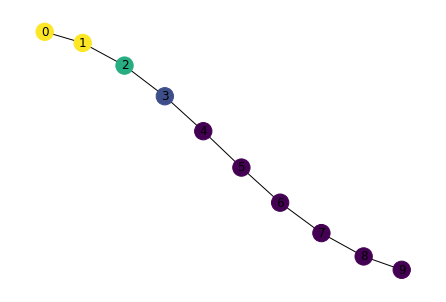

In [220]:
est = [x[i] if i in S_prime else x_T_prime[np.where(T_prime == i)][0] for i in range(m)]
nx.draw(G, with_labels=True, node_color = est)

In [222]:
def synthetic_speeds(G):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
    order = np.argsort(eigs[0])
    
    vals = 1e8 * eigs[1][:,-1]
    speeds = {}
    for i, v in enumerate(nx.line_graph(G).nodes()):
        speeds[v] = vals[i]
    return speeds

In [ ]:
def speed_prediction_lu(P, T, lu, piv, x_T):
    x_intermediate = lu_solve((lu, piv), P_TS_prime @ x_S_prime)


In [481]:
import random

random.seed(3)

def weightedL2(a, b, w):
    q = a-b
    return (w*q*q).sum()

def choose_sensors_lu(G, labeled_edges, weights, k=None, debug=False):
    if k == None:
        k = int(G.number_of_edges() / 10)
        
    m = G.number_of_edges()
    
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    x = np.array([labeled_edges[reverse[v]] for v in range(m)])
    w = np.array([weights[reverse[v]] for v in range(m)])
    
    # Choose random sensors
    C = [mapping[k] for k in labeled_edges]
    S = C[:k]
    T = sorted(list(set(C) - set(S)))
    
    # Initial prediction
    P = transition_matrix(line_G)
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    lu, piv = lu_factor(np.identity(m-k) - P_TT)

    x_S = x[np.ix_(S)]
    x_T_hat = lu_solve((lu, piv), P_TS @ x_S)
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in range(k):
            # Move sensor i to a more optimal placement
            subgraph = nx.ego_graph(line_G, S[i], 1)
            nbrs = list(set(subgraph.nodes()).intersection(set(C)).difference(set(S)))
            candidates = random.sample(nbrs, min(10, len(nbrs)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                swap = np.where(np.array(T) == v)[0][0]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = P[np.ix_(T_prime, T_prime)]
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                U = np.zeros((m-k, 2))
                V = np.zeros((2, m-k))
                for j in range(m-k):
                    if j == swap:
                        U[j][0] = 1
                        V[0][j] = 1
                    else:
                        U[j][1] = P_TT[j][swap] - P_TT_prime[j][swap]
                        V[1][j] = P_TT[swap][j] - P_TT_prime[swap][j]
                        
                perm = np.array([[0, 1],
                                [1, 0]])
                
#                 if not np.allclose(P_TT_prime, P_TT - U @ perm @ V):
#                     print("Rank 2 update invalid")
#                     print(P_TT, "\n", P_TT_prime)
#                     print(T, T_prime, swap)
#                     print(P_TT - P_TT_prime)
#                     print(U @ perm @ V)
#                     return
                
                x_int = lu_solve((lu, piv), P_TS_prime @ x_S_prime)
                Y = scipy.linalg.lu_solve((lu, piv), U)
                x_T_prime = x_int - Y @ np.linalg.inv(perm + V @ Y) @ V @ x_int
                
                # Check correctness
#                 if not np.allclose((np.identity(m-k) - P_TT_prime) @ x_T_prime, P_TS_prime @ x_S_prime):
#                     print("Update error: invalid least squares solution. SSE: ")
#                     print(np.linalg.norm((np.identity(m-k) - P_TT_prime) @ x_T_prime - P_TS_prime @ x_S_prime))
#                     return
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime, x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                    
                    # Recompute LU decomposition
                    lu, piv = lu_factor(np.identity(m-k) - P_TT)
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

choose_sensors_lu(G, synthetic_speeds(G), {e: 1 for e in G.edges()}, k=3, debug=True)

iteration 0 current error 8.863686e+15
end of iteration 0 improvement 6.548606e+15
iteration 1 current error 2.315080e+15
end of iteration 1 improvement 1.934542e+15
iteration 2 current error 3.805387e+14
end of iteration 2 improvement 0.000000e+00


[(0, 1), (8, 9), (4, 5)]

In [475]:
import random

random.seed(3)

def choose_sensors_lsmr(G, labeled_edges, weights, k=None, debug=False):        
    m = G.number_of_edges()
    
    if k == None:
        k = int(m / 10)
    
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    x = np.array([labeled_edges[reverse[v]] for v in line_G.nodes()])
    w = np.array([weights[reverse[v]] for v in line_G.nodes()])
    
    # Choose random sensors
    C = [mapping[k] for k in labeled_edges]
    S = C[:k]
    T = sorted(list(set(C) - set(S)))
    
    # Initial prediction
    P = transition_matrix(line_G)
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    x_S = x[np.ix_(S)]
    x_T_hat = linalg.lsmr(np.identity(m-k) - P_TT, P_TS @ x_S)[0]
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in range(k):
            # Move sensor i to a more optimal placement
            subgraph = nx.ego_graph(line_G, S[i], 1)
            nbrs = list(set(subgraph.nodes()).intersection(set(C)).difference(set(S)))
            candidates = random.sample(nbrs, min(10, len(nbrs)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = P[np.ix_(T_prime, T_prime)]
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                x_T_prime = linalg.lsmr(np.identity(m-k) - P_TT_prime, P_TS_prime @ x_S_prime)[0]
                
                # Check correctness
#                 if not np.allclose((np.identity(m-k) - P_TT_prime) @ x_T_prime, P_TS_prime @ x_S_prime):
#                     print("Update error: invalid least squares solution. SSE: ")
#                     print(np.linalg.norm((np.identity(m-k) - P_TT_prime) @ x_T_prime - P_TS_prime @ x_S_prime))
#                     return
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime, x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                    
                    # Recompute LU decomposition
                    lu, piv = lu_factor(np.identity(m-k) - P_TT)
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

choose_sensors_lsmr(G, synthetic_speeds(G), {e: 1 for e in G.edges()}, k=3, debug=True)

iteration 0 current error 8.863686e+15
end of iteration 0 improvement 6.843756e+15
iteration 1 current error 2.019930e+15
end of iteration 1 improvement 3.454903e+14
iteration 2 current error 1.674440e+15
end of iteration 2 improvement 4.276008e+14
iteration 3 current error 1.246839e+15
end of iteration 3 improvement 0.000000e+00


[(0, 1), (8, 9), (5, 6)]

## Traffic Networks

In [439]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ")
    flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    speeds = synthetic_speeds(G)
    return G, flows, speeds

In [445]:
Berlin = nx.from_pandas_edgelist(pd.read_csv("data/Berlin-Tiergarten/berlin-tiergarten_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
EMA = nx.from_pandas_edgelist(pd.read_csv("data/Eastern-Massachusetts/EMA_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
LA = nx.from_pandas_edgelist(pd.read_csv("out/small.results.csv"), source="edge_from", target="edge_to")

In [517]:
speeds = synthetic_speeds(Berlin)
weights = {e: 1 for e in Berlin.edges()}
%prun -s cumulative choose_sensors_lu(Berlin, speeds, weights, k=20)

In [515]:
%prun -s cumulative choose_sensors_lsmr(Berlin, synthetic_speeds(Berlin), {e: 1 for e in Berlin.edges()}, k=20)

In [484]:
from sklearn.cluster import SpectralClustering

def spectral_clustering_speeds(G, k):
    '''
        Graph should be undirected.
        Node ids should be integers starting from 0.
    '''
    line_graph = nx.line_graph(G.to_undirected(), create_using=nx.Graph())
    
    A = nx.to_numpy_array(line_graph)
    sc = SpectralClustering(n_clusters=k, assign_labels='discretize', affinity='precomputed', random_state=0).fit(A)
    membership = sc.labels_
    nodes = list(line_graph.nodes())
    selected = []
    
    for i in range(k):
        part = np.argwhere(np.array(membership) == i).ravel()

        #selecting a random node in the partition
        if len(part) > 0:
            selected.append(np.random.choice(part))
        else:
            selected.append(np.random.choice(list(set(range(len(membership))) - set(selected))))
                
    return [nodes[u] for u in selected]

In [485]:
def flow_weighted_error(flows):
    def evaluate(pred, labels):
        err = 0
        for k, v in labels.items():
            err += (flows[k] * (v - pred[k])) ** 2
        return err
    
    return evaluate

In [498]:
def err(G, sensors, labels, i, error=mse):
    preds = speed_prediction(G, {s: labels[s] for s in sensors[:i]})
    return error(preds, labels)

In [487]:
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def flow_weighted_corr(G, flows):
    return lambda preds, labels: corr(dict2vect(G, preds), dict2vect(G, labels), dict2vect(G, flows))

In [510]:
def get_speed_results(G, flows, speeds, ratio, samples=50, debug=False):
    k = int(G.number_of_edges() * ratio)
    fwe = flow_weighted_error(flows)
    fwcorr = flow_weighted_corr(G, flows)
    
    random_sensors = choose_sensors_random(G, k)
    random_corr, greedy_corr, cluster_corr = {0: 0}, {0: 0}, {0: 0}
        
    for j in tqdm(range(1, samples + 1)):
        i = int(k * j / samples)
        
        cluster_sensors = spectral_clustering_speeds(G, i)
        greedy_sensors = choose_sensors_lu(G, speeds, weights=flows, k=i, debug=debug)
        
        random_corr[i / G.number_of_edges()] = max(err(G, random_sensors, speeds, i, error=fwcorr), 0)
        greedy_corr[i / G.number_of_edges()] = max(err(G, greedy_sensors, speeds, i, error=fwcorr), 0)
        cluster_corr[i / G.number_of_edges()] = max(err(G, cluster_sensors, speeds, i, error=fwcorr), 0)
        
    return {
        "random": random_corr,
        "greedy": greedy_corr,
        "spectral": cluster_corr
    }

In [511]:
sensors = {}

In [514]:
%prun -s cumulative choose_sensors_lu(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), k=300)

In [512]:
sensors["Anaheim"] = get_speed_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 1)

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [499]:
from sensors import choose_sensors_random

def plot_speed_results(results, ax, title="", xlabel=False, ylabel=False, legend=False):
    ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "black", label="Random",
           linewidth=3, linestyle="dashed")
    ax.plot(results["spectral"].keys(), results["spectral"].values(), "darkgreen", label="Spectral Clustering",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)
    
    return overall_sensors

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

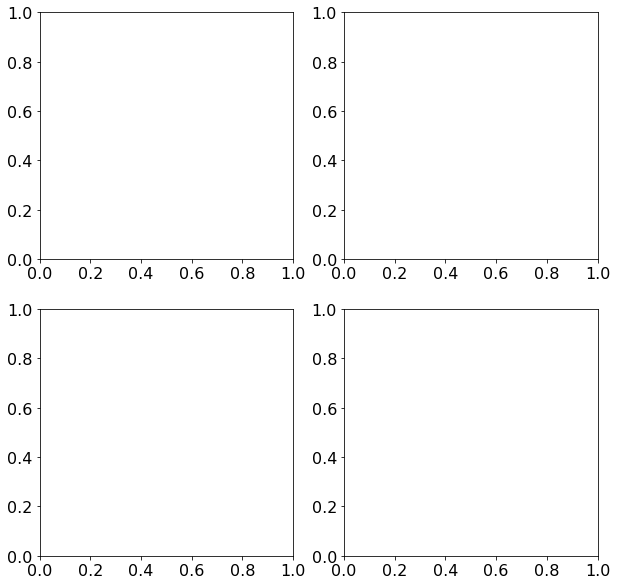

In [501]:
import matplotlib

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sensors["Anaheim"] = plot_speed_results(ax[0][0], title="Anaheim", ylabel=True, legend=True)

plt.savefig("results/synthetic_speeds.pdf")

In [ ]:
import json

with open("data/Anaheim/anaheim_nodes.geojson") as f:
    features = json.loads(f.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, coords, node_size=2, edge_color = ["green" if e in greedy_sensors[:50] else "black" for e in G.edges()],
       width = [5 if e in greedy_sensors[:50] else 1 for e in G.edges()])

In [ ]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, coords, node_size=2, edge_color = [flows[e] for e in G.edges()])

In [ ]:
preds = speed_prediction(G, {s: speeds[s] for s in greedy_sensors[:50]})
fwcorr(preds, speeds)